## Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from skimage.transform import rotate
from shapely.geometry.polygon import Polygon
from argoverse.visualization.visualize_sequences import viz_sequence

In [2]:
## map
am = ArgoverseMap()

##set root_dir to the correct path to your dataset folder
root_dir = '../LaneGCN/dataset/val/data/'
afl = ArgoverseForecastingLoader(root_dir)

## Choose sequence

In [3]:
index = 3
obs_len = 20
seq_path = afl.seq_list[index]
agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
city = afl[index].city

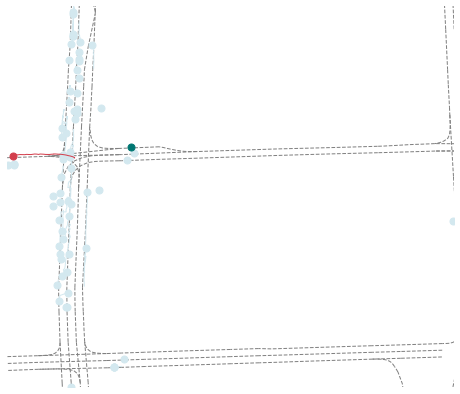

In [4]:
index = 3
seq_path = afl.seq_list[index]
viz_sequence(afl.get(seq_path).seq_df, show=True)

## Wisdom from paper:

We use all actors and lanes whose distance from the agent
is smaller than 100 meters as the input. 

The coordinate system in our model is the
BEV centered at the agent location at t = 0. 

We use the orientation from the agent location at t = −1 
to the agent location at t = 0 as the positive x axis.

In [5]:
### define config ###
config = dict()
config["pred_range"] = [-100.0, 100.0, -100.0, 100.0]
orig = agent_obs_traj[19].copy().astype(np.float32)

x_min, x_max, y_min, y_max = config['pred_range']
radius = max(abs(x_min), abs(x_max)) + max(abs(y_min), abs(y_max))
lane_ids = am.get_lane_ids_in_xy_bbox(orig[0], orig[1], city, radius)
lane_ids = copy.deepcopy(lane_ids)
print('Number of lane-ids in the radius of orig: ', len(lane_ids)) 

Number of lane-ids in the radius of orig:  583


In [6]:
pre = agent_obs_traj[18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])

rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]], np.float32)

## Lane Graph

In [7]:
### Reduce lane-ids for compute ###
lane_ids = lane_ids[:10]

---------------------------------------------
------Example of getting lane polygon (should be a right turn) --------
---------------------------------------------


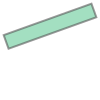

In [8]:
### get centerlines and polygons for each lane ###
lanes = dict()
for ix, lane_id in enumerate(lane_ids):
    lane = am.city_lane_centerlines_dict[city][lane_id]
    lane = copy.deepcopy(lane)
    centerline = np.matmul(rot, (lane.centerline - orig.reshape(-1, 2)).T).T
    x, y = centerline[:, 0], centerline[:, 1]
    if x.max() < x_min or x.min() > x_max or y.max() < y_min or y.min() > y_max:
        continue # can exclude some lanes here
    else:
        """Getting polygons requires original centerline"""
        polygon = am.get_lane_segment_polygon(lane_id, city)
        polygon = copy.deepcopy(polygon)
        lane.centerline = centerline
        lane.polygon = np.matmul(rot, (polygon[:, :2] - orig.reshape(-1, 2)).T).T
        if ix==0:    
            print('---------------------------------------------')
            print('------Example of getting lane polygon (should be a right turn) --------')
            print('---------------------------------------------')
            display(Polygon(lane.polygon))
        if ix==5:    
            print('---------------------------------------------')
            print('------Example of getting lane polygon (should be a left turn)--------')
            print('---------------------------------------------')
            display(Polygon(lane.polygon))
        lanes[lane_id] = lane

In [9]:
###  fill in lane segment centers, lane segment features ###
###  fill in lane segment turn dir, whether it has traffic control, is at intersection or not ###

lane_ids = list(lanes.keys())
ctrs, feats, turn, control, intersect = [], [], [], [], []
for lane_id in lane_ids:
    lane = lanes[lane_id]
    ctrln = lane.centerline
    num_segs = len(ctrln) - 1

    ctrs.append(np.asarray((ctrln[:-1] + ctrln[1:]) / 2.0, np.float32)) # average of lane ends
    feats.append(np.asarray(ctrln[1:] - ctrln[:-1], np.float32)) # v(end)-v(start) as feature

    x = np.zeros((num_segs, 2), np.float32)
    if lane.turn_direction == 'LEFT':
        x[:, 0] = 1
    elif lane.turn_direction == 'RIGHT':
        x[:, 1] = 1
    else:
        pass
    turn.append(x) # turn direction [0, 0] if none, [0,1] if right, [1,0] if left

    control.append(lane.has_traffic_control * np.ones(num_segs, np.float32)) # does lane segment have traffic control
    intersect.append(lane.is_intersection * np.ones(num_segs, np.float32)) # is lane segment at intersection
    
print("How many segments in lane 1: ", len(turn[0]))
print("Turn for lane1: right turning lane ", turn[0])
print("Does this lane have traffic control: yes ", control[0])
print("Is this right turn at an intersection: yes ", intersect[0], "\n")

print("How many segments in lane 6: ", len(turn[-2]))
print("Turn for lane1: left turning lane ", turn[-2])
print("Does this lane have traffic control: yes ", control[-2])
print("Is this left turn at an intersection: yes ", intersect[-2])

How many segments in lane 1:  9
Turn for lane1: right turning lane  [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
Does this lane have traffic control: yes  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Is this right turn at an intersection: yes  [0. 0. 0. 0. 0. 0. 0. 0. 0.] 

How many segments in lane 6:  9
Turn for lane1: left turning lane  [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Does this lane have traffic control: yes  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Is this left turn at an intersection: yes  [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
## each segment is a node, count number ##
node_idcs = []
count = 0
for i, ctr in enumerate(ctrs):
    node_idcs.append(range(count, count + len(ctr)))
    count += len(ctr)
num_nodes = count
print("Check node indices for every lane: \n", node_idcs)

Check node indices for every lane: 
 [range(0, 9), range(9, 18), range(18, 27)]


In [11]:
### fill in the neighbor-predecessor adjacencies###
### v is the predecessor of u in pre###
### v is the sucessor of u in suc###

pre, suc = dict(), dict()
for key in ['u', 'v']:
    pre[key], suc[key] = [], []
    
for i, lane_id in enumerate(lane_ids):
    lane = lanes[lane_id]
    idcs = node_idcs[i]
    
    # for a lane-segment we already know its predecessors
    # fill them in order (u's predecessor is v)
    pre['u'] += idcs[1:]
    pre['v'] += idcs[:-1]

    if lane.predecessors is not None:
        # for the beginning of the lane, do we know its predecessor lane segment? (idcs[0]'s predecessor)
        # if we do, fill it in with the last node of the previous lane segment (node_idcs[j][-1])
        for nbr_id in lane.predecessors:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                pre['u'].append(idcs[0])
                pre['v'].append(node_idcs[j][-1])
                
    
    # for a lane-segment we already know its successors
    # fill them in order (u's sucessor is v)
    suc['u'] += idcs[:-1]
    suc['v'] += idcs[1:]
    if lane.successors is not None:
        for nbr_id in lane.successors:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                suc['u'].append(idcs[-1]) # (idcs[-1]'s sucessor)
                suc['v'].append(node_idcs[j][0]) #node_idcs[j][0]

                
#print
print("##---Pre-----##")
for i,j in pre.items():
    print(i, ": ", "\n", j,"\n")
    
print("##---Suc-----##")
for i,j in suc.items():
    print(i, ": ", "\n", j,"\n")
    

# fill in all the nodes with their ids with respect to their lane segments
print("##---Lane-idcs-----##")
print("Number of nodes total: ", num_nodes)
print("Which lanes do the nodes belong to?")
lane_idcs = []
for i, idcs in enumerate(node_idcs):
    lane_idcs.append(i * np.ones(len(idcs), np.int64))
lane_idcs = np.concatenate(lane_idcs, 0)
print(lane_idcs)

##---Pre-----##
u :  
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26] 

v :  
 [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25] 

##---Suc-----##
u :  
 [0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25] 

v :  
 [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26] 

##---Lane-idcs-----##
Number of nodes total:  27
Which lanes do the nodes belong to?
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2]


In [12]:
pre_pairs, suc_pairs, left_pairs, right_pairs = [], [], [], []
for i, lane_id in enumerate(lane_ids):
    lane = lanes[lane_id]
    
    # pred_name: get the id of the lane i, search for its predecessor
    # item_no: search its predecessor name pred_name in the lane_ids
    # i,item_no are pre-pairs
    nbr_ids = lane.predecessors
    if nbr_ids is not None:
        for nbr_id in nbr_ids:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                pre_pairs.append([i, j])
                
    nbr_ids = lane.successors
    if nbr_ids is not None:
        for nbr_id in nbr_ids:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                suc_pairs.append([i, j])

    nbr_id = lane.l_neighbor_id
    if nbr_id is not None:
        if nbr_id in lane_ids:
            j = lane_ids.index(nbr_id)
            left_pairs.append([i, j])

    nbr_id = lane.r_neighbor_id
    if nbr_id is not None:
        if nbr_id in lane_ids:
            j = lane_ids.index(nbr_id)
            right_pairs.append([i, j])
            
            
pre_pairs = np.asarray(pre_pairs, np.int64)
suc_pairs = np.asarray(suc_pairs, np.int64)
left_pairs = np.asarray(left_pairs, np.int64)
right_pairs = np.asarray(right_pairs, np.int64)

print("Pre-pairs: ", pre_pairs)
print("Suc-pairs: ", suc_pairs)
print("Left-pairs: ", left_pairs)
print("Right-pairs: ", right_pairs)

Pre-pairs:  []
Suc-pairs:  []
Left-pairs:  []
Right-pairs:  []


## Check a real-world case

In [13]:
def dilated_nbrs(nbr, num_nodes, num_scales):
    data = np.ones(len(nbr['u']), np.bool)
    csr = sparse.csr_matrix((data, (nbr['u'], nbr['v'])), shape=(num_nodes, num_nodes))

    mat = csr
    nbrs = []
    for i in range(1, num_scales):
        mat = mat * mat

        nbr = dict()
        coo = mat.tocoo()
        nbr['u'] = coo.row.astype(np.int64)
        nbr['v'] = coo.col.astype(np.int64)
        nbrs.append(nbr)
    return nbrs


def dilated_nbrs2(nbr, num_nodes, scales):
    data = np.ones(len(nbr['u']), np.bool)
    csr = sparse.csr_matrix((data, (nbr['u'], nbr['v'])), shape=(num_nodes, num_nodes))

    mat = csr
    nbrs = []
    for i in range(1, max(scales)):
        mat = mat * csr

        if i + 1 in scales:
            nbr = dict()
            coo = mat.tocoo()
            nbr['u'] = coo.row.astype(np.int64)
            nbr['v'] = coo.col.astype(np.int64)
            nbrs.append(nbr)
    return nbrs

In [14]:
afl.seq_list = sorted(afl.seq_list)

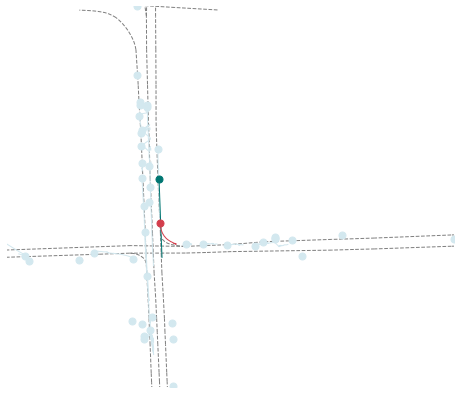

In [15]:
index = 500
obs_len = 20
seq_path = afl[index]
agent_obs_traj = afl[index].agent_traj[:obs_len]
city = afl[index].city

seq_path = afl.seq_list[index]
viz_sequence(afl.get(seq_path).seq_df, show=True)

In [16]:
### define config ###
config = dict()
config["pred_range"] = [-100.0, 100.0, -100.0, 100.0]
orig = agent_obs_traj[19].copy().astype(np.float32)
config["num_scales"] = 6

x_min, x_max, y_min, y_max = config['pred_range']
radius = max(abs(x_min), abs(x_max)) + max(abs(y_min), abs(y_max))
lane_ids = am.get_lane_ids_in_xy_bbox(orig[0], orig[1], city, radius)
lane_ids = copy.deepcopy(lane_ids)
print('Number of lane-ids in the radius of orig: ', len(lane_ids)) 

pre = agent_obs_traj[18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])

rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]], np.float32)

Number of lane-ids in the radius of orig:  417


In [17]:
### get centerlines and polygons for each lane ###
lanes = dict()
for ix, lane_id in enumerate(lane_ids):
    lane = am.city_lane_centerlines_dict[city][lane_id]
    lane = copy.deepcopy(lane)
    centerline = np.matmul(rot, (lane.centerline - orig.reshape(-1, 2)).T).T
    x, y = centerline[:, 0], centerline[:, 1]
    if x.max() < x_min or x.min() > x_max or y.max() < y_min or y.min() > y_max:
        continue # can exclude some lanes here
    else:
        """Getting polygons requires original centerline"""
        polygon = am.get_lane_segment_polygon(lane_id, city)
        polygon = copy.deepcopy(polygon)
        lane.centerline = centerline
        lane.polygon = np.matmul(rot, (polygon[:, :2] - orig.reshape(-1, 2)).T).T
        lanes[lane_id] = lane

In [18]:
###  fill in lane segment centers, lane segment features ###
###  fill in lane segment turn dir, whether it has traffic control, is at intersection or not ###

lane_ids = list(lanes.keys())
ctrs, feats, turn, control, intersect = [], [], [], [], []
for lane_id in lane_ids:
    lane = lanes[lane_id]
    ctrln = lane.centerline
    num_segs = len(ctrln) - 1

    ctrs.append(np.asarray((ctrln[:-1] + ctrln[1:]) / 2.0, np.float32)) # average of lane ends
    feats.append(np.asarray(ctrln[1:] - ctrln[:-1], np.float32)) # v(end)-v(start) as feature

    x = np.zeros((num_segs, 2), np.float32)
    if lane.turn_direction == 'LEFT':
        x[:, 0] = 1
    elif lane.turn_direction == 'RIGHT':
        x[:, 1] = 1
    else:
        pass
    turn.append(x) # turn direction [0, 0] if none, [0,1] if right, [1,0] if left

    control.append(lane.has_traffic_control * np.ones(num_segs, np.float32)) # does lane segment have traffic control
    intersect.append(lane.is_intersection * np.ones(num_segs, np.float32)) # is lane segment at intersection
    
## each segment is a node, count number ##
node_idcs = []
count = 0
for i, ctr in enumerate(ctrs):
    node_idcs.append(range(count, count + len(ctr)))
    count += len(ctr)
num_nodes = count

### fill in the neighbor-predecessor adjacencies###
### v is the predecessor of u in pre###
### v is the sucessor of u in suc###

pre, suc = dict(), dict()
for key in ['u', 'v']:
    pre[key], suc[key] = [], []
    
for i, lane_id in enumerate(lane_ids):
    lane = lanes[lane_id]
    idcs = node_idcs[i]
    
    # for a lane-segment we already know its predecessors
    # fill them in order (u's predecessor is v)
    pre['u'] += idcs[1:]
    pre['v'] += idcs[:-1]

    if lane.predecessors is not None:
        # for the beginning of the lane, do we know its predecessor lane segment? (idcs[0]'s predecessor)
        # if we do, fill it in with the last node of the previous lane segment (node_idcs[j][-1])
        for nbr_id in lane.predecessors:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                pre['u'].append(idcs[0])
                pre['v'].append(node_idcs[j][-1])
                
    
    # for a lane-segment we already know its successors
    # fill them in order (u's sucessor is v)
    suc['u'] += idcs[:-1]
    suc['v'] += idcs[1:]
    if lane.successors is not None:
        for nbr_id in lane.successors:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                suc['u'].append(idcs[-1]) # (idcs[-1]'s sucessor)
                suc['v'].append(node_idcs[j][0]) #node_idcs[j][0]
    
    lane_idcs = []
    for i, idcs in enumerate(node_idcs):
        lane_idcs.append(i * np.ones(len(idcs), np.int64))
    lane_idcs = np.concatenate(lane_idcs, 0)
                
    pre_pairs, suc_pairs, left_pairs, right_pairs = [], [], [], []
    for i, lane_id in enumerate(lane_ids):
        lane = lanes[lane_id]

        # pred_name: get the id of the lane i, search for its predecessor
        # item_no: search its predecessor name pred_name in the lane_ids
        # i,item_no are pre-pairs
        nbr_ids = lane.predecessors
        if nbr_ids is not None:
            for nbr_id in nbr_ids:
                if nbr_id in lane_ids:
                    j = lane_ids.index(nbr_id)
                    pre_pairs.append([i, j])

        nbr_ids = lane.successors
        if nbr_ids is not None:
            for nbr_id in nbr_ids:
                if nbr_id in lane_ids:
                    j = lane_ids.index(nbr_id)
                    suc_pairs.append([i, j])

        nbr_id = lane.l_neighbor_id
        if nbr_id is not None:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                left_pairs.append([i, j])

        nbr_id = lane.r_neighbor_id
        if nbr_id is not None:
            if nbr_id in lane_ids:
                j = lane_ids.index(nbr_id)
                right_pairs.append([i, j])


pre_pairs = np.asarray(pre_pairs, np.int64)
suc_pairs = np.asarray(suc_pairs, np.int64)
left_pairs = np.asarray(left_pairs, np.int64)
right_pairs = np.asarray(right_pairs, np.int64)

In [19]:
graph = dict()
graph['ctrs'] = np.concatenate(ctrs, 0)
graph['num_nodes'] = num_nodes
graph['feats'] = np.concatenate(feats, 0)
graph['turn'] = np.concatenate(turn, 0)
graph['control'] = np.concatenate(control, 0)
graph['intersect'] = np.concatenate(intersect, 0)
graph['pre'] = [pre]
graph['suc'] = [suc]
graph['lane_idcs'] = lane_idcs
graph['pre_pairs'] = pre_pairs
graph['suc_pairs'] = suc_pairs
graph['left_pairs'] = left_pairs
graph['right_pairs'] = right_pairs

for k1 in ['pre', 'suc']:
    for k2 in ['u', 'v']:
        graph[k1][0][k2] = np.asarray(graph[k1][0][k2], np.int64)

for key in ['pre', 'suc']:
    graph[key] += dilated_nbrs(graph[key][0], graph['num_nodes'], config['num_scales'])

2*Total pairs:  362


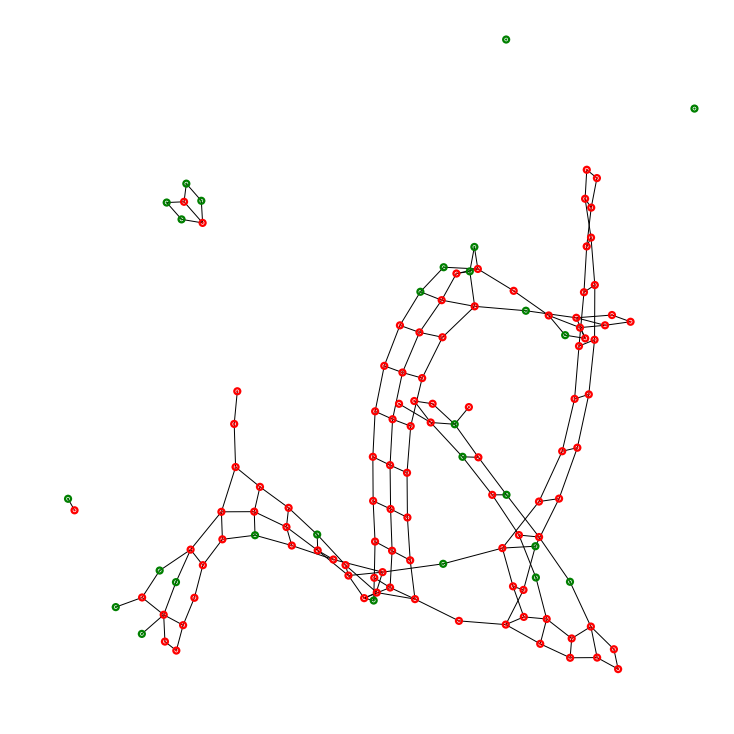

In [20]:
import networkx as nx
import torch_geometric
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import to_networkx


# Get total adjacency matrix
total_pairs = np.concatenate([graph['pre_pairs'], 
                             graph['suc_pairs'],
                             graph['left_pairs'],
                             graph['right_pairs']], 0)

print('2*Total pairs: ', len(total_pairs))

# Edge tensor and actual data tensor
edge_index = torch.tensor(np.concatenate([total_pairs, 
                                          np.fliplr(total_pairs)], 
                                         0), dtype=torch.long).t().contiguous()
x = torch.tensor(np.unique(total_pairs), dtype=torch.float) # node numbers

# Feed into torch geometric
data = torch_geometric.data.Data(x=x, edge_index=edge_index)
# Convert to networkx
g = torch_geometric.utils.to_networkx(data, to_undirected=True)

# Visualize 
color_map = []
for node in g:
    if graph['intersect'][node]>0:
        color_map.append('red')
    else: 
        color_map.append('green')
color_map = np.array(color_map)
plt.figure(1,figsize=(10,10)) 
nx.draw(g, cmap=plt.get_cmap('Set1'),node_size=5,node_color=color_map, linewidths=6)
plt.show()